In [1]:
import pandas as pd
import numpy as np


In [2]:
# for managing class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler

In [3]:
# for plotting 
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [4]:
# define parameters
interval= True
WS_level=0.8
make_gridsearch=True
make_kfold=True
K_folds=5

In [5]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,ComplementNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
import pickle
import os
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [6]:
# create folder to save models
models_loc='mymodels4wells_for_2d_2/'
if not os.path.exists(models_loc):
    os.makedirs(models_loc)

In [7]:
# read data
logs_df = pd.read_csv("Data/logs_4wells.csv")
seismic_df=pd.read_csv('data/seismic_4wells.csv')
stack_section2=pd.read_csv('data/section_2D_2.csv')

In [8]:
seismic_df
sqrInsF = seismic_df['InstF'] *seismic_df['InstF']
sqrInsF
InF = np.sqrt(sqrInsF)
sqrtInsF = np.sqrt(InF)
sweetness = seismic_df['AmpEnv']/sqrtInsF
seismic_df['Sweetness'] = sweetness
seismic_df.loc[seismic_df['InstF'] <0,'Sweetness'] = seismic_df.loc[seismic_df['InstF'] <0,'Sweetness'] * -1 
seismic_df


,Time,Seismic,log_ID,QuadrTrace,SecDerInstAmpl,Integrated,AWCP,Der,AWF,DomF,InstF,SecDer,AmpEnv,AppPolr,Sweetness
0,0.0,1.857250e-07,6507_2-4,0.000000,0.000003,-1.458270e-07,-0.002556,-3.714510e-08,0.435150,11.2305,0.587815,0.000000e+00,0.002723,0.002723,0.003551
1,4.0,1.485800e-07,6507_2-4,0.000000,0.000003,2.364560e-08,-0.002496,-3.714510e-08,0.424978,11.2305,-0.586274,0.000000e+00,0.002651,0.002651,-0.003462
2,8.0,-4.952680e-08,6507_2-4,0.000000,0.000003,-2.943440e-09,-0.002478,-1.981070e-07,0.421835,11.2305,0.573187,-1.609620e-07,0.002629,0.002629,0.003472
3,12.0,1.981070e-07,6507_2-4,0.000000,-0.000003,2.088340e-07,-0.002418,2.476340e-07,0.411794,11.2305,-0.576099,4.457410e-07,0.002558,0.002558,-0.003371
4,16.0,5.262220e-08,6507_2-4,0.000000,0.000003,2.766920e-07,-0.002399,-1.454850e-07,0.408441,11.2305,0.564944,-3.931190e-07,0.002535,0.002535,0.003373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3292,3484.0,5.801160e+00,6507_2-2,3.549570,-0.025161,6.979550e+00,5.798760,-1.829830e+00,172.873000,23.9258,26.082000,-3.220880e+00,6.628050,6.628050,1.297823
3293,3488.0,2.199700e+00,6507_2-2,5.568090,-0.042255,9.189250e+00,1.868830,-3.601460e+00,130.720000,23.9258,26.731100,-1.771630e+00,4.890190,4.890190,0.945839
3294,3492.0,-1.175990e+00,6507_2-2,4.508560,-0.026934,8.030300e+00,-0.597739,-3.375690e+00,54.293700,23.9258,19.950700,2.257690e-01,2.721400,2.721400,0.609275
3295,3496.0,-3.029810e+00,6507_2-2,2.665140,0.034085,5.024380e+00,-0.452218,-1.853820e+00,-10.679600,23.9258,-9.726790,1.521870e+00,1.097960,1.097960,-0.352048


In [9]:
stack_section2.columns.tolist()

['Time', 'Imp', 'Trace', 'Porosity', 'Density', 'V_clay', 'P_wave', 'Seismic']

In [10]:
logs_df.isna().sum()

Time                0
Density             0
P_wave              0
Porosity            0
V_clay              0
Water Saturation    0
log_ID              0
Horison             0
Imp                 0
dtype: int64

In [11]:
logs_df

,Time,Density,P_wave,Porosity,V_clay,Water Saturation,log_ID,Horison,Imp
0,514.8757,1.2545,1577.8733,0.0557,0.4820,1.0,6507_2-1,2D-mid,1979.442055
1,515.0686,1.2542,1579.8525,0.0550,0.4766,1.0,6507_2-1,2D-mid,1981.451006
2,515.2613,1.2724,1581.8326,0.0579,0.5014,1.0,6507_2-1,2D-mid,2012.723800
3,515.4538,1.2821,1583.8119,0.0592,0.5126,1.0,6507_2-1,2D-mid,2030.605237
4,515.6460,1.2897,1585.7920,0.0601,0.5201,1.0,6507_2-1,2D-mid,2045.195942
...,...,...,...,...,...,...,...,...,...
74748,2788.0627,2.5312,2730.6299,0.1232,0.7761,1.0,6507_3-9S,2D-K65,6911.770403
74749,2788.1743,2.4875,2727.8901,0.1487,0.7458,1.0,6507_3-9S,2D-K65,6785.626624
74750,2788.2861,2.4531,2725.1487,0.1668,0.7255,1.0,6507_3-9S,2D-K65,6685.062276
74751,2788.3979,2.4308,2722.4080,0.1769,0.7027,1.0,6507_3-9S,2D-K65,6617.629366


In [12]:
logs_df = logs_df[(logs_df['Time']>=1050) & (logs_df['Time']<=2850)].reset_index(drop=True)
logs_df = logs_df[(logs_df['Time']>=1050) & (logs_df['Time']<=3200)].reset_index(drop=True)



'''logs_df =logs_df[(logs_df['log_ID']=='6507_3-9s') & (logs_df['Time']>=2650) & (logs_df['Time']<=2800)].append(
        logs_df[(logs_df['log_ID']=='6507_2-4') & (logs_df['Time']>=2670) & (logs_df['Time']<=2800)]).append(
        logs_df[(logs_df['log_ID']=='6507_2-2') & (logs_df['Time']>=2666) & (logs_df['Time']<=2800)]).append(
        logs_df[(logs_df['log_ID']=='6507_2-1') & (logs_df['Time']>=2674) & (logs_df['Time']<=2840)]).reset_index(drop=True) '''


"logs_df =logs_df[(logs_df['log_ID']=='6507_3-9s') & (logs_df['Time']>=2650) & (logs_df['Time']<=2800)].append(\n        logs_df[(logs_df['log_ID']=='6507_2-4') & (logs_df['Time']>=2670) & (logs_df['Time']<=2800)]).append(\n        logs_df[(logs_df['log_ID']=='6507_2-2') & (logs_df['Time']>=2666) & (logs_df['Time']<=2800)]).append(\n        logs_df[(logs_df['log_ID']=='6507_2-1') & (logs_df['Time']>=2674) & (logs_df['Time']<=2840)]).reset_index(drop=True) "

In [13]:
#logs_df.groupby(['log_ID','Time']).mean()

In [14]:
#logs_df.loc[10:20]
logs_df

,Time,Density,P_wave,Porosity,V_clay,Water Saturation,log_ID,Horison,Imp
0,1050.0450,2.0322,2190.8054,0.0776,0.6714,1.0,6507_2-1,2D-mid,4452.154734
1,1050.1869,2.0291,2181.9836,0.0783,0.6776,1.0,6507_2-1,2D-mid,4427.462923
2,1050.3293,2.0260,2173.2310,0.0790,0.6839,1.0,6507_2-1,2D-mid,4402.966006
3,1050.4731,2.0009,2151.1841,0.0776,0.6716,1.0,6507_2-1,2D-mid,4304.304266
4,1050.6184,1.9758,2129.5786,0.0762,0.6593,1.0,6507_2-1,2D-mid,4207.621398
...,...,...,...,...,...,...,...,...,...
48770,2788.0627,2.5312,2730.6299,0.1232,0.7761,1.0,6507_3-9S,2D-K65,6911.770403
48771,2788.1743,2.4875,2727.8901,0.1487,0.7458,1.0,6507_3-9S,2D-K65,6785.626624
48772,2788.2861,2.4531,2725.1487,0.1668,0.7255,1.0,6507_3-9S,2D-K65,6685.062276
48773,2788.3979,2.4308,2722.4080,0.1769,0.7027,1.0,6507_3-9S,2D-K65,6617.629366


# # Opposite Moving Average

In [15]:
features = seismic_df.columns.to_list()
features.remove('log_ID')
features
def opposite_mov_avg(data):
    
    data_1=(data+data.shift(1))/2
    data_1=data.append(data_1.dropna()).sort_values('Time').reset_index(drop=True)
    data_2=(data_1+data_1.shift(1))/2
    data_2=data_1.append(data_2.dropna()).sort_values('Time').reset_index(drop=True)
    return data_2
seismic_df_extra_points=opposite_mov_avg(seismic_df[seismic_df['log_ID']=='6507_2-1'][features])
seismic_df_extra_points

,Time,Seismic,QuadrTrace,SecDerInstAmpl,Integrated,AWCP,Der,AWF,DomF,InstF,SecDer,AmpEnv,AppPolr,Sweetness
0,0.0,-7.548390e-08,0.002513,0.000018,-5.314120e-07,-0.000959,-2.516130e-08,0.008822,20.0195,5.453330,0.000000,0.001618,-1.617760e-03,0.000693
1,1.0,-8.177418e-08,0.002471,0.000018,-5.588895e-07,-0.000951,-2.516130e-08,0.004422,20.0195,2.603595,0.000000,0.001582,-1.213345e-03,0.000368
2,2.0,-8.806445e-08,0.002428,0.000018,-5.863670e-07,-0.000943,-2.516130e-08,0.000022,20.0195,-0.246140,0.000000,0.001547,-8.089303e-04,0.000044
3,3.0,-9.435473e-08,0.002386,0.000018,-6.138445e-07,-0.000935,-2.516130e-08,-0.004377,20.0195,-3.095875,0.000000,0.001512,-4.045155e-04,-0.000281
4,4.0,-1.006450e-07,0.002343,0.000018,-6.413220e-07,-0.000927,-2.516130e-08,-0.008777,20.0195,-5.945610,0.000000,0.001476,-1.006450e-07,-0.000605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3696,3696.0,6.878200e-01,0.099278,0.006486,1.406940e-01,0.100497,-6.171700e-02,3.223610,24.4141,28.761200,-0.539050,0.112082,-1.120820e-01,0.020899
3697,3697.0,5.898730e-01,0.167429,0.007825,2.535495e-01,0.075077,-1.442345e-01,2.288616,24.4141,9.070900,-0.486805,0.086643,-8.664332e-02,0.015309
3698,3698.0,4.919260e-01,0.235581,0.009164,3.664050e-01,0.049657,-2.267520e-01,1.353623,24.4141,-10.619400,-0.434560,0.061205,-6.120465e-02,0.009719
3699,3699.0,3.939790e-01,0.303733,0.010503,4.792605e-01,0.024237,-3.092695e-01,0.418629,24.4141,-30.309700,-0.382315,0.035766,-3.576597e-02,0.004129


In [16]:
count=0
#features = seismic_df.columns.to_list()
seismic_df_extra_points=[]
for log_id in seismic_df['log_ID'].value_counts().index.to_list():
    
    df_extra_points=opposite_mov_avg(seismic_df[seismic_df['log_ID']==log_id][features])
    df_extra_points['log_ID']=log_id
    
    if count==0:
        seismic_df_extra_points=df_extra_points
    else:
        seismic_df_extra_points=seismic_df_extra_points.append(df_extra_points)
    
    count=count+1

In [17]:
seismic_df_extra_points

,Time,Seismic,QuadrTrace,SecDerInstAmpl,Integrated,AWCP,Der,AWF,DomF,InstF,SecDer,AmpEnv,AppPolr,Sweetness,log_ID
0,0.0,-7.548390e-08,0.002513,0.000018,-5.314120e-07,-0.000959,-2.516130e-08,0.008822,20.0195,5.453330,0.000000,0.001618,-1.617760e-03,0.000693,6507_2-1
1,1.0,-8.177418e-08,0.002471,0.000018,-5.588895e-07,-0.000951,-2.516130e-08,0.004422,20.0195,2.603595,0.000000,0.001582,-1.213345e-03,0.000368,6507_2-1
2,2.0,-8.806445e-08,0.002428,0.000018,-5.863670e-07,-0.000943,-2.516130e-08,0.000022,20.0195,-0.246140,0.000000,0.001547,-8.089303e-04,0.000044,6507_2-1
3,3.0,-9.435473e-08,0.002386,0.000018,-6.138445e-07,-0.000935,-2.516130e-08,-0.004377,20.0195,-3.095875,0.000000,0.001512,-4.045155e-04,-0.000281,6507_2-1
4,4.0,-1.006450e-07,0.002343,0.000018,-6.413220e-07,-0.000927,-2.516130e-08,-0.008777,20.0195,-5.945610,0.000000,0.001476,-1.006450e-07,-0.000605,6507_2-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2796,2796.0,2.021190e-01,-0.519607,0.002647,-1.905970e+00,0.030192,2.949970e-01,-0.049926,29.2969,-0.189041,-0.091461,0.264099,-2.640990e-01,-0.607420,6507_3-9S
2797,2797.0,2.409712e-01,-0.410583,0.004051,-1.807952e+00,0.022794,2.601000e-01,-0.206187,29.2969,-1.087418,-0.103493,0.242685,-2.426850e-01,-0.478502,6507_3-9S
2798,2798.0,2.798235e-01,-0.301558,0.005456,-1.709935e+00,0.015396,2.252030e-01,-0.362447,29.2969,-1.985796,-0.115524,0.221271,-2.212710e-01,-0.349585,6507_3-9S
2799,2799.0,3.186758e-01,-0.192534,0.006860,-1.611918e+00,0.007998,1.903060e-01,-0.518708,29.2969,-2.884173,-0.127556,0.199857,-1.998570e-01,-0.220668,6507_3-9S


## Opposite Moving Average and Moving Average Implementation

In [18]:
opposite_mov_avg=False
if opposite_mov_avg==True:
    logs_df['Time_rounded']=np.round(logs_df['Time']/1)*1
    horison_vect = logs_df.groupby(['log_ID','Time_rounded'])['Horison'].first().values
    logs_df=logs_df.groupby(['log_ID','Time_rounded']).mean().reset_index().drop('Time', axis=1).rename(columns={'Time_rounded': 'Time'})
    logs_df['Horison'] = horison_vect
    
    log_seismic_df=pd.merge(logs_df,seismic_df_extra_points, how='inner', on=['log_ID','Time']).sort_values(['log_ID','Time'])
    #log_seismic_df = pd.merge(l,seismic_df_extra_points,on=['log_ID','Time'])

else:
    logs_av = logs_df
    logs_av['Time_rounded'] = np.round(logs_av['Time']/4)*4
    horison_vect = logs_av.groupby(['log_ID','Time_rounded'])['Horison'].first().values
    logs_av = logs_av.groupby(['log_ID','Time_rounded']).mean()
    logs_av['Horison'] = horison_vect
    logs_av.reset_index(inplace=True)
    logs_av.drop('Time',axis=1, inplace=True)
    logs_av = logs_av.rename(columns={'Time_rounded':'Time'})
    # Combining the logs_avg and seismic dataframes picking only unique values of time and log_id present in the two dataframes
    log_seismic_df = pd.merge(logs_av,seismic_df,on=['log_ID','Time'])
    


In [19]:
seismic_df.isna().sum()

Time              0
Seismic           0
log_ID            0
QuadrTrace        0
SecDerInstAmpl    0
Integrated        0
AWCP              0
Der               0
AWF               0
DomF              0
InstF             0
SecDer            0
AmpEnv            0
AppPolr           0
Sweetness         0
dtype: int64

In [20]:
log_id_list = logs_df['log_ID'].value_counts().index.tolist()

In [21]:
log_id_list

['6507_2-1', '6507_2-4', '6507_3-9S', '6507_2-2']

In [22]:
def plot_per_log(df, column_name, type_p='-',color=['blue','blue','blue','blue']):
    # plot Time vs Paramater for each well on separate subgraph
    log_ID_list=df['log_ID'].value_counts().index.tolist()
    fig, ax = plt.subplots(1,len(log_ID_list),figsize=(15,10))
    
    for i in list(range(len(log_ID_list))):
        ax[i].plot(df[df['log_ID']==log_ID_list[i]][column_name], -df[df['log_ID']==log_ID_list[i]]['Time'],type_p, color=color[i])
        ax[i].set_xlabel(column_name)
        ax[i].set_title(log_ID_list[i])
        
    ax[0].set_ylabel('Time')

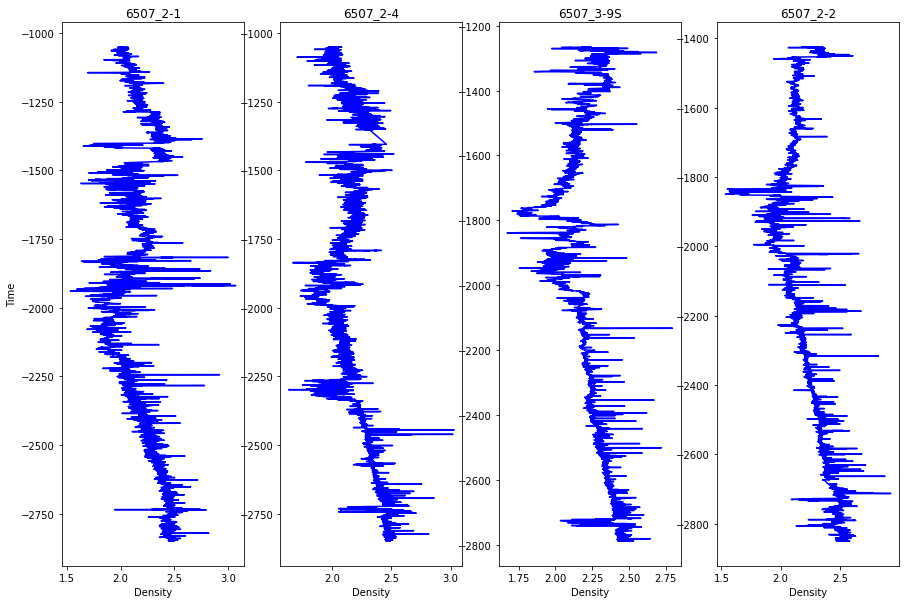

In [23]:
plot_per_log(logs_df,'Density')


In [24]:
# Plotting Time vs density for each well on separate subgraphs
column_name = 'Density'


In [25]:
log_id_list

['6507_2-1', '6507_2-4', '6507_3-9S', '6507_2-2']

In [26]:
# Checking for intervals with low water saturation from log data
#logs_av[(logs_av['Water Saturation'] <= 0.6)]
#l_av[(l_av['Water Saturation'] <= 0.9)]
log_seismic_df[(log_seismic_df['Water Saturation'] <= 0.9)]

,log_ID,Time,Density,P_wave,Porosity,V_clay,Water Saturation,Imp,Horison,Seismic,...,Integrated,AWCP,Der,AWF,DomF,InstF,SecDer,AmpEnv,AppPolr,Sweetness
763,6507_2-2,2676.0,2.366500,2724.600450,0.247100,0.380200,0.887650,6447.750699,2D-mid2,-1.521020,...,-2.660840,-1.523320,0.151197,36.2145,24.8383,20.9275,0.475559,1.730470,-1.730470,0.378273
775,6507_2-2,2728.0,2.317681,2923.576530,0.203734,0.182015,0.720074,6835.753064,2D-K65,-1.417350,...,-2.075750,-1.422450,0.628147,57.1652,25.1495,28.4909,0.989837,2.006440,-2.006440,0.375901
776,6507_2-2,2732.0,2.311010,2724.520286,0.218462,0.245055,0.831690,6300.347575,2D-K65,-0.111237,...,-2.207460,-0.121428,1.306120,54.5327,25.1460,29.1088,0.677971,1.873410,-1.873410,0.347233
1212,6507_2-4,2724.0,2.362210,3148.410908,0.196003,0.406174,0.736941,7450.541994,2D-mid2,-1.012620,...,-1.321540,-1.014810,0.370982,-177.7580,24.9359,24.2085,0.578495,1.208050,-1.208050,0.245528
1213,6507_2-4,2728.0,2.252677,3055.198041,0.244877,0.211067,0.471254,6885.904961,2D-K65,-0.385151,...,-1.752770,-0.391447,0.627474,-113.4770,24.8575,23.7428,0.256492,1.004880,-1.004880,0.206228
1214,6507_2-4,2732.0,2.189074,3050.609685,0.276218,0.204156,0.356477,6674.819444,2D-K65,0.157264,...,-1.622770,0.150134,0.542416,-61.6137,24.7836,23.6042,-0.085058,0.780774,-0.780774,0.160705
1215,6507_2-4,2736.0,2.308738,3100.371949,0.226141,0.326665,0.662478,7171.865171,2D-K65,0.383543,...,-1.244400,0.379770,0.226278,-24.8116,24.7141,22.4743,-0.316137,0.543384,-0.543384,0.114621
1607,6507_3-9S,2720.0,2.393925,3444.631115,0.167873,0.157780,0.618635,8284.068836,2D-K65,-2.498640,...,-1.738950,-2.498630,-0.236192,59.6954,29.2969,23.6882,0.817925,2.520050,-2.520050,0.517777
1608,6507_3-9S,2724.0,2.245811,2993.767309,0.239280,0.134120,0.422646,6733.525283,2D-K65,-1.815910,...,-3.568580,-1.815650,0.682730,58.0283,29.2969,23.8643,0.918922,2.431590,-2.431590,0.497755
1609,6507_3-9S,2728.0,2.215457,2961.150063,0.254480,0.106331,0.466203,6568.439012,2D-K65,-0.538252,...,-4.117100,-0.537685,1.277660,54.8635,29.2969,24.1656,0.594929,2.270310,-2.270310,0.461834


In [27]:
log_seismic_df.columns

Index(['log_ID', 'Time', 'Density', 'P_wave', 'Porosity', 'V_clay',
       'Water Saturation', 'Imp', 'Horison', 'Seismic', 'QuadrTrace',
       'SecDerInstAmpl', 'Integrated', 'AWCP', 'Der', 'AWF', 'DomF', 'InstF',
       'SecDer', 'AmpEnv', 'AppPolr', 'Sweetness'],
      dtype='object')

In [28]:
log_seismic_df['log_ID'].value_counts()
#log_seismic_df.isna().sum

6507_2-1     450
6507_2-4     438
6507_3-9S    381
6507_2-2     356
Name: log_ID, dtype: int64

Columns to use
Columns that exist in both 2d seismic and data for wells.

In [30]:
features = log_seismic_df.columns.intersection(stack_section2.columns).to_list()
features
features = ['Density', 'P_wave','Porosity','Imp' , 'V_clay'] #FOR 3D SECTION AND 2D SECTION WITH WELLS ABSENT

We now split the data into train and validation set
The target is Water Saturation and only horizons 2D-K65,2D-BCU, 2D-bottom

In [31]:
df = log_seismic_df[(log_seismic_df['Horison']=='2D-K65')|(log_seismic_df['Horison']=='2D-BCU')|(log_seismic_df['Horison']=='2D-mid2')]


In [32]:
df['Horison'].value_counts()

2D-mid2    905
2D-K65      94
Name: Horison, dtype: int64

In [33]:
# defining test, target, features
test_well_name = '6507_2-4'
target_val=0.9

In [34]:
df['target'] = 0
df

,log_ID,Time,Density,P_wave,Porosity,V_clay,Water Saturation,Imp,Horison,Seismic,...,AWCP,Der,AWF,DomF,InstF,SecDer,AmpEnv,AppPolr,Sweetness,target
196,6507_2-1,1836.0,1.865180,1995.942908,0.181788,0.674056,1.0,3727.971495,2D-mid2,-0.538545,...,-0.539715,1.855940,83.8727,20.1918,20.2535,0.789704,4.141150,4.141150,0.920176,0
197,6507_2-1,1840.0,1.919430,2072.824122,0.201115,0.647763,1.0,3981.194682,2D-mid2,1.540610,...,1.539570,2.079150,83.3950,20.2479,19.6154,0.223206,4.251510,4.251510,0.959941,0
198,6507_2-1,1844.0,2.050561,2191.257196,0.156904,0.701825,1.0,4495.013770,2D-mid2,3.311070,...,3.310560,1.770460,85.2538,20.3071,19.5134,-0.308686,4.368980,4.368980,0.989039,0
199,6507_2-1,1848.0,2.064218,2227.875786,0.157536,0.687446,1.0,4612.202204,2D-mid2,4.427660,...,4.427610,1.116590,92.2328,20.3693,20.3720,-0.653875,4.527420,4.527420,1.003076,0
200,6507_2-1,1852.0,2.040321,2271.261386,0.230897,0.600286,1.0,4653.714379,2D-mid2,4.434920,...,4.434800,0.007255,98.1797,20.4346,21.0747,-1.109330,4.658660,4.658660,1.014800,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1620,6507_3-9S,2772.0,2.462435,2821.728600,0.159973,0.727278,1.0,6948.195398,2D-K65,-0.585401,...,-0.585008,-0.388663,17.0488,29.2969,17.0910,-0.045212,0.997527,-0.997527,0.241291,0
1621,6507_3-9S,2776.0,2.435376,2818.600397,0.175062,0.705462,1.0,6864.353695,2D-K65,-0.892463,...,-0.892323,-0.307061,18.1421,29.2969,17.8150,0.081602,1.018360,-1.018360,0.241273,0
1622,6507_3-9S,2780.0,2.471103,2812.135657,0.158430,0.739238,1.0,6949.902279,2D-K65,-0.987688,...,-0.987687,-0.095226,18.1957,29.2969,18.3990,0.211836,0.988954,-0.988954,0.230557,0
1623,6507_3-9S,2784.0,2.452608,2785.768038,0.165576,0.699203,1.0,6832.026304,2D-K65,-0.827980,...,-0.827870,0.159708,19.1803,29.2969,20.9444,0.254934,0.915771,-0.915771,0.200103,0


In [35]:
df.loc[df['Water Saturation'] <= target_val,'target']= 1

In [36]:
df[df['target']==1]

,log_ID,Time,Density,P_wave,Porosity,V_clay,Water Saturation,Imp,Horison,Seismic,...,AWCP,Der,AWF,DomF,InstF,SecDer,AmpEnv,AppPolr,Sweetness,target
763,6507_2-2,2676.0,2.366500,2724.600450,0.247100,0.380200,0.887650,6447.750699,2D-mid2,-1.521020,...,-1.523320,0.151197,36.2145,24.8383,20.9275,0.475559,1.730470,-1.730470,0.378273,1
775,6507_2-2,2728.0,2.317681,2923.576530,0.203734,0.182015,0.720074,6835.753064,2D-K65,-1.417350,...,-1.422450,0.628147,57.1652,25.1495,28.4909,0.989837,2.006440,-2.006440,0.375901,1
776,6507_2-2,2732.0,2.311010,2724.520286,0.218462,0.245055,0.831690,6300.347575,2D-K65,-0.111237,...,-0.121428,1.306120,54.5327,25.1460,29.1088,0.677971,1.873410,-1.873410,0.347233,1
1212,6507_2-4,2724.0,2.362210,3148.410908,0.196003,0.406174,0.736941,7450.541994,2D-mid2,-1.012620,...,-1.014810,0.370982,-177.7580,24.9359,24.2085,0.578495,1.208050,-1.208050,0.245528,1
1213,6507_2-4,2728.0,2.252677,3055.198041,0.244877,0.211067,0.471254,6885.904961,2D-K65,-0.385151,...,-0.391447,0.627474,-113.4770,24.8575,23.7428,0.256492,1.004880,-1.004880,0.206228,1
1214,6507_2-4,2732.0,2.189074,3050.609685,0.276218,0.204156,0.356477,6674.819444,2D-K65,0.157264,...,0.150134,0.542416,-61.6137,24.7836,23.6042,-0.085058,0.780774,-0.780774,0.160705,1
1215,6507_2-4,2736.0,2.308738,3100.371949,0.226141,0.326665,0.662478,7171.865171,2D-K65,0.383543,...,0.379770,0.226278,-24.8116,24.7141,22.4743,-0.316137,0.543384,-0.543384,0.114621,1
1607,6507_3-9S,2720.0,2.393925,3444.631115,0.167873,0.157780,0.618635,8284.068836,2D-K65,-2.498640,...,-2.498630,-0.236192,59.6954,29.2969,23.6882,0.817925,2.520050,-2.520050,0.517777,1
1608,6507_3-9S,2724.0,2.245811,2993.767309,0.239280,0.134120,0.422646,6733.525283,2D-K65,-1.815910,...,-1.815650,0.682730,58.0283,29.2969,23.8643,0.918922,2.431590,-2.431590,0.497755,1
1609,6507_3-9S,2728.0,2.215457,2961.150063,0.254480,0.106331,0.466203,6568.439012,2D-K65,-0.538252,...,-0.537685,1.277660,54.8635,29.2969,24.1656,0.594929,2.270310,-2.270310,0.461834,1


In [37]:
df.isna().sum()

log_ID              0
Time                0
Density             0
P_wave              0
Porosity            0
V_clay              0
Water Saturation    0
Imp                 0
Horison             0
Seismic             0
QuadrTrace          0
SecDerInstAmpl      0
Integrated          0
AWCP                0
Der                 0
AWF                 0
DomF                0
InstF               0
SecDer              0
AmpEnv              0
AppPolr             0
Sweetness           0
target              0
dtype: int64

In [38]:
df[(df['Water Saturation'] != 1)]

,log_ID,Time,Density,P_wave,Porosity,V_clay,Water Saturation,Imp,Horison,Seismic,...,AWCP,Der,AWF,DomF,InstF,SecDer,AmpEnv,AppPolr,Sweetness,target
215,6507_2-1,1912.0,2.205843,2698.650423,0.186423,0.699600,0.986103,6342.783383,2D-mid2,2.350780,...,2.350160,-0.150057,74.04150,21.7797,21.7413,-0.842494,3.405560,-3.405560,0.730375,0
427,6507_2-1,2760.0,2.447191,2992.740583,0.185889,0.604431,0.999414,7324.198128,2D-mid2,-0.130709,...,-0.131886,0.596477,22.19680,21.8682,18.1450,-0.020413,1.223300,-1.223300,0.287180,0
576,6507_2-2,1928.0,2.007090,2516.902445,0.193241,0.572817,0.996459,5159.825469,2D-mid2,-3.086450,...,-3.087160,-0.907934,75.79410,21.0562,23.6784,0.986678,3.200970,-3.200970,0.657818,0
762,6507_2-2,2672.0,2.403140,2851.784251,0.170317,0.647791,0.993540,6855.744826,2D-mid2,-1.672210,...,-1.672220,-0.324362,35.56940,24.7988,21.2609,0.390934,1.673000,-1.673000,0.362832,0
763,6507_2-2,2676.0,2.366500,2724.600450,0.247100,0.380200,0.887650,6447.750699,2D-mid2,-1.521020,...,-1.523320,0.151197,36.21450,24.8383,20.9275,0.475559,1.730470,-1.730470,0.378273,1
764,6507_2-2,2684.0,2.415632,2658.138064,0.199468,0.424773,0.924895,6422.402340,2D-mid2,-0.030507,...,-0.040734,0.887094,36.27330,24.9249,20.6129,0.283680,1.759740,-1.759740,0.387596,0
775,6507_2-2,2728.0,2.317681,2923.576530,0.203734,0.182015,0.720074,6835.753064,2D-K65,-1.417350,...,-1.422450,0.628147,57.16520,25.1495,28.4909,0.989837,2.006440,-2.006440,0.375901,1
776,6507_2-2,2732.0,2.311010,2724.520286,0.218462,0.245055,0.831690,6300.347575,2D-K65,-0.111237,...,-0.121428,1.306120,54.53270,25.1460,29.1088,0.677971,1.873410,-1.873410,0.347233,1
777,6507_2-2,2736.0,2.519400,2867.161511,0.120452,0.539944,0.998993,7218.925723,2D-K65,1.067830,...,1.061580,1.179060,50.37380,25.1385,29.5873,-0.127054,1.702550,-1.702550,0.313002,0
783,6507_2-2,2760.0,2.441378,2936.525295,0.162170,0.524393,0.998835,7157.972143,2D-K65,-1.044710,...,-1.044820,-0.118784,26.37870,25.0096,25.1090,0.345223,1.050570,-1.050570,0.209657,0


In [39]:
test_df = df[df['log_ID']==test_well_name]
test_df = test_df[(test_df['Time'] >2300)]
X_test = test_df[features]
y_test = test_df['target']

data = df[df['log_ID']!=test_well_name]
X = data[features]
y = data['target']
inbalance = True
if (inbalance == True):
    #SM = SMOTE(random_state=42)
    #smt = SMOTETomek(random_state=42)
    sme = SMOTEENN(random_state=42)
    #sm_nc = SMOTENC(categorical_features=[0])
    #X,y = SM.fit_resample(X,y)    #Implementing smote
    #X,y = smt.fit_resample(X,y)
    X,y = sme.fit_resample(X,y)
    #X,y = sm_nc.fit_resample(X,y)

In [40]:
np.bincount(y)
y
#X

0       0
1       0
2       0
3       0
4       0
       ..
1402    1
1403    1
1404    1
1405    1
1406    1
Name: target, Length: 1407, dtype: int64

In [41]:
count = 0
myList = []
for i in X.index.to_list():
    if i not in data.index.to_list():
        myList.append(i)
        count += 1
#print(myList)
X = X.drop(myList)   # Removing data points generated by Smote Algorithm not in original data index this removes unrealistic points if you consider geology
#data.index.to_list()


In [42]:

yList = []
for i in y.index.to_list():
    
    if i not in data.index.to_list():
        yList.append(i)
        count += 1
        #print(i)
#print(yList)
y = y.drop(yList) # Removing data points generated by Smote Algorithm not in original data index this removes unrealistic points if you consider geology


In [43]:
y[(y==1)].count()
y

196     0
197     0
198     0
199     0
200     0
       ..
1402    1
1403    1
1404    1
1405    1
1406    1
Name: target, Length: 526, dtype: int64

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3 , random_state=42)

In [45]:
X_test

,Density,P_wave,Porosity,Imp,V_clay
1107,1.951348,2225.352586,0.214355,4342.385801,0.639066
1108,2.017759,2283.453841,0.225486,4608.647261,0.626700
1109,2.053093,2257.887787,0.212773,4636.362911,0.641850
1110,2.019959,2264.168745,0.218200,4570.131558,0.635676
1111,1.922060,2335.356247,0.222617,4489.552920,0.631100
...,...,...,...,...,...
1239,2.490900,2897.330606,0.127429,7217.005401,0.741285
1240,2.474883,2940.379600,0.144320,7277.235021,0.708206
1241,2.477705,2962.441403,0.144962,7339.957209,0.703197
1242,2.471013,3021.342763,0.149637,7465.794985,0.681932


In [46]:
y_train[(y_train==1)].count()

82

#  Build pipeline

In [47]:
# find numerical and categorical column names
numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = X.select_dtypes(include=['object', 'bool']).columns
print(numerical_ix)
print(categorical_ix)

Index(['Density', 'P_wave', 'Porosity', 'Imp', 'V_clay'], dtype='object')
Index([], dtype='object')


In [48]:
# Trying to understand the encoding process
'''from sklearn import preprocessing
enc = preprocessing.OneHotEncoder()
Z = [['male'], ['female'],['animal'],['well']]
enc.fit(Z)
enc.transform([['male']]).toarray()'''

"from sklearn import preprocessing\nenc = preprocessing.OneHotEncoder()\nZ = [['male'], ['female'],['animal'],['well']]\nenc.fit(Z)\nenc.transform([['male']]).toarray()"

In [49]:
# column transformation
# categorical columns -> One Hot Encoding
# numerical column -> Scaling

t = [('cat', OneHotEncoder(drop="first"), categorical_ix), ('num',StandardScaler(), numerical_ix)]

col_transform = ColumnTransformer(transformers=t)

In [50]:
#data1=section_stack_df[(section_stack_df['Time'] >2630)]
#data1 = section_stack_df
#data1=stack_section2[(stack_section2['Time'] >1050)] 


data1 = stack_section2

In [51]:
def prec_recall_report(y_true,y_pred):
    prec, recall,fscore,support = precision_recall_fscore_support(y_true, y_pred, average='binary')
    print('Precision: ', prec)
    print('Recall: ', recall)
    print('F-score: ', fscore)
    
def f1_score_eval(y_true, y_pred):
    prec, recall, fscore, support = precision_recall_fscore_support(y_true,y_pred,average='binary')
    return fscore

def prec_recall_fscore_train_val_test(clf, X_train, y_train, X_val, y_val,X_test,y_test):
    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_val)
    y_test_pred = clf.predict(X_test)
    
    print('Precision/Recall/ F-score on train set : \n')
    prec_recall_report(y_train, y_train_pred)
    
    print('\n Precision/ Recall/ F-score on validation set : \n')
    prec_recall_report(y_val, y_val_pred)
    
    print('\n Precision/ Recall/ F-score on test set : \n')
    prec_recall_report(y_test, y_test_pred)
    
    return y_train_pred, y_val_pred, y_test_pred

def plot_real_predicted(X_train, y_train, y_train_pred, X_val, y_val, y_val_pred, X_test, y_test, y_test_pred, title_text, logs=data, logs_4=test_df):
    fig, ax = plt.subplots(1,3,figsize=(15,8))

    
    #plot y_train Vs y_train_pred 
    ax[0].plot(y_train,-logs.loc[X_train.index.to_list()]['Time'], 'b.' , alpha=0.5)
    ax[0].plot(y_train_pred+0.015,-logs.loc[y_train.index.to_list()]['Time'], 'r.' , alpha=0.5)
    ax[0].legend(['original', 'predicted']);
    ax[0].set_xlabel('1-oil / 0-otherwise');
    ax[0].set_ylabel('Time');
    ax[0].set_title('train set'); 
    
    
    ax[1].plot(y_val,-logs.loc[X_val.index.to_list()]['Time'], 'b.' , alpha=0.5)
    ax[1].plot(y_val_pred+0.015,-logs.loc[y_val.index.to_list()]['Time'], 'r.' , alpha=0.5)
    ax[1].legend(['original', 'predicted']);
    ax[1].set_xlabel('1-oil / 0-otherwise');
    ax[1].set_ylabel('Time');
    ax[1].set_title('validation set'); 
    
    #plot y_test VS y_test_pred
    ax[2].plot(y_test,-logs_4['Time'], 'b.' , alpha=0.5)
    ax[2].plot(y_test_pred+0.015,-logs_4['Time'], 'r.' , alpha=0.5)
    ax[2].legend(['original', 'predicted']);
    ax[2].set_title('test set');    
    ax[2].set_xlabel('1-oil / 0-otherwise');
    
    fig.suptitle(title_text, fontsize=16)

    

In [52]:
def predict_section(df1, method_name, method, features=features):
    df1['Pred']=method.predict(df1[features])

    df2=df1[['Trace','Time', 'Pred']].groupby(['Time', 'Trace'])['Pred'].aggregate('first').unstack()
    plt.figure(figsize=(20, 10))
    plt.title (method_name)
    ax = sb.heatmap(df2,vmin=0, vmax=1, cmap="YlGnBu") #"YlOrRd"

In [53]:
def output_function(clf, clf_name, X_train, y_train, X_val, y_val, X_test, y_test):
    y_train_pred, y_val_pred, y_test_pred=prec_recall_fscore_train_val_test(clf, 
                                                                        X_train, y_train, 
                                                                        X_val, y_val, 
                                                                        X_test, y_test)
    
    plot_real_predicted(X_train, y_train, y_train_pred, X_val, y_val, y_val_pred, X_test, y_test, y_test_pred, clf_name)
    predict_section(data1.dropna(), '2D section1 - '+clf_name ,  clf )

In [54]:
def kfold_gridsearch_function(clf, parameters, X, Y, K_folds):
    
    cv= RepeatedStratifiedKFold(n_splits=K_folds, n_repeats=3, random_state=1)
    search = GridSearchCV(clf, parameters, scoring='f1', n_jobs=-1, cv=cv)
    result = search.fit(X, Y)
    print('Best Hyperparameters: %s' % result.best_params_, '\n')
    print('Mean test score: %s' % result.best_score_, '\n')
    print('Std test score: %s' % result.cv_results_['std_test_score'][result.cv_results_['rank_test_score']==1].tolist()[0], '\n')
    
    return result

In [55]:
def grid_search_function(clf, parameters, X_train, y_train):
    
    cv = GridSearchCV(clf,  param_grid=parameters, scoring = 'f1')
    cv.fit(X_train, y_train)
    print (cv.best_params_)
    
    return cv

# # Define algorithms and hyper parameters 

In [56]:
# Logistic regression
log_reg = Pipeline([('prep', col_transform), ('clf', LogisticRegression(random_state=54))])
log_reg_params = {'clf__solver': ['newton-cg', 'lbfgs', 'liblinear'],'clf__penalty':['l2','l1'],'clf__C':[100, 10, 1.0, 0.1, 0.01]}
## -------------------------------------------------------------------
# Gaussian Naive Bayes
gnb = Pipeline([('prep', col_transform), ('clf', GaussianNB())])
gnb_params = {'clf__var_smoothing': [0.00000001, 0.000000001, 0.0000000001]}
## -------------------------------------------------------------------
# Support Vector Machine
svm = Pipeline([('prep',col_transform), ('clf', SVC(random_state=40))])
svm_params = {'clf__kernel':['poly', 'rbf', 'sigmoid'], 'clf__gamma': ['scale'], 'clf__C':[50, 10, 1.0, 0.1, 0.01] }
## --------------------------------------------------------------------
# Gradient boosting classifier
gbc = Pipeline([('prep', col_transform), ('clf', GradientBoostingClassifier(random_state=42))])
gbc_params = {'clf__n_estimators': [10, 100, 1000], 'clf__learning_rate': [0.001, 0.01, 0.1], 'clf__subsample':[0.5, 0.7, 1.0], 'clf__max_depth': [3,7,9] }
 ## ------------------------------------------------------------------
# Multi-layer Perceptron classifier
mlpc = Pipeline([
    ('prep',col_transform), 
    ('clf', MLPClassifier(random_state=42))
     ])
mlpc_params = {
    'clf__hidden_layer_sizes': [(30, 10), (60,50,10), (150,)], 
    'clf__activation': ['tanh', 'relu'], 
    'clf__solver': ['sgd', 'adam'], 
    'clf__alpha': [0.0001, 0.05], 
    'clf__learning_rate': ['constant','adaptive'],
    'clf__max_iter': [50],
    'clf__batch_size': [100],
    'clf__random_state':[42],
    'clf__nesterovs_momentum':[True],
    'clf__momentum':[True]
}

### Logistic regression

In [56]:
# Logistic Regression
log_reg = Pipeline([
    ('prep', col_transform),
    ('clf', LogisticRegression(solver='lbfgs',random_state=42))
])

log_reg.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index([], dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['Density', 'P_wave', 'Porosity', 'Imp', 'V_clay'], dtype='object'))])),
                ('clf', LogisticRegression(random_state=42))])

Precision/Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on validation set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0


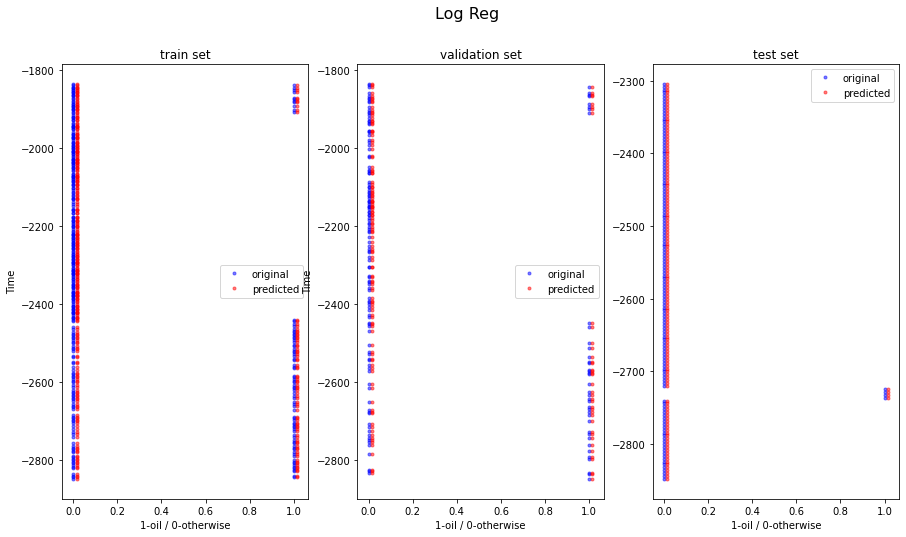

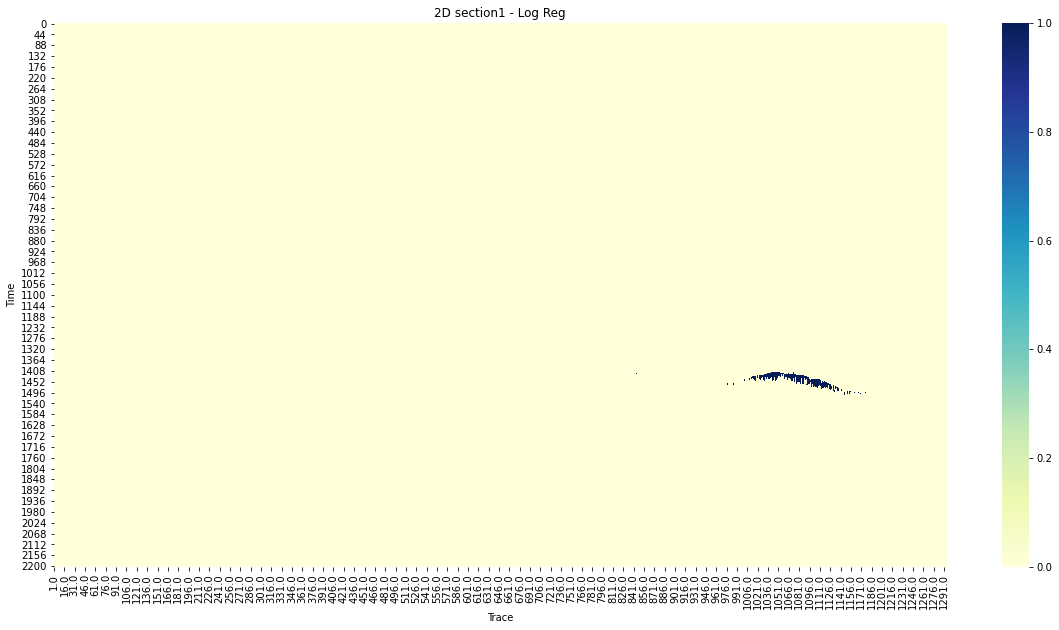

In [57]:
#y_train_pred, y_val_pred, y_test_pred = prec_recall_fscore_train_val_test(log_reg,X_train, y_train, X_val, y_val, X_test, y_test)

#plot_real_predicted(X_val, y_val, y_val_pred, X_test, y_test, y_test_pred, 'Log Reg')
output_function(log_reg, 'Log Reg', X_train, y_train, X_val, y_val, X_test, y_test)

{'clf__C': 100, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg'}
Precision/Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on validation set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0


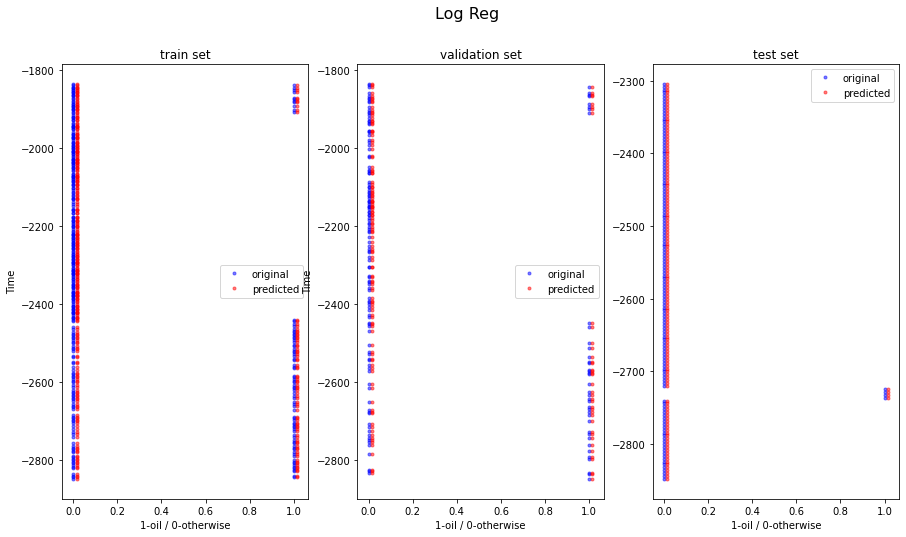

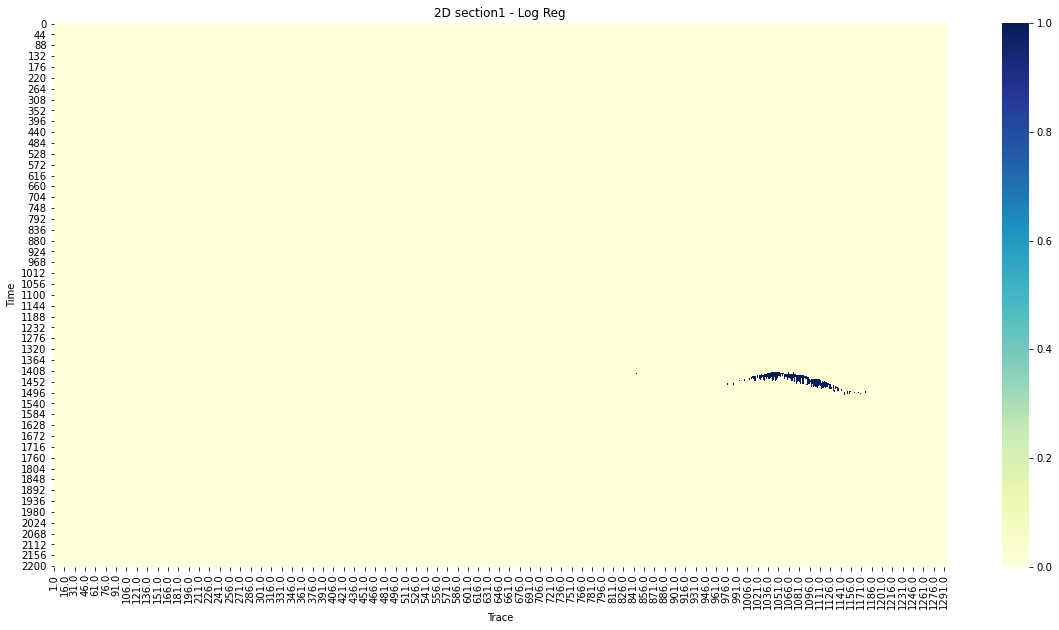

In [58]:
make_gridsearch1=True
if make_gridsearch1==True:
    cv=grid_search_function(log_reg, log_reg_params, X_train, y_train)
    output_function(cv, 'Log Reg', X_train, y_train, X_val, y_val, X_test, y_test)
    
    # save model to the .pkl file
    filename = 'log_reg_gs.pkl'
    pickle.dump(cv, open(models_loc+filename, 'wb'))

Best Hyperparameters: {'clf__C': 100, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg'} 

Mean test score: 1.0 

Std test score: 0.0 

Precision/Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on validation set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0


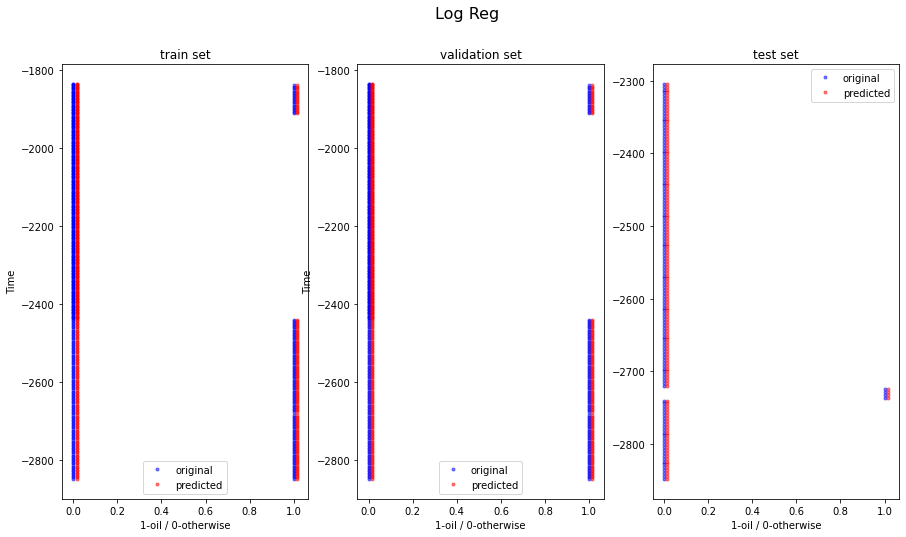

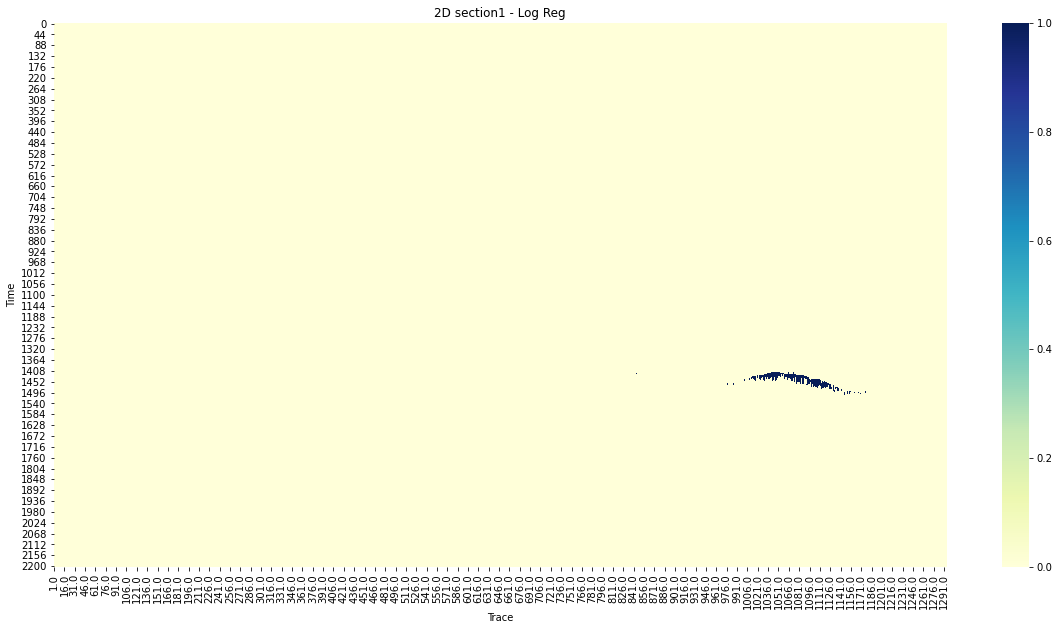

In [59]:
make_kfold1=True
if make_kfold1==True:
    result=kfold_gridsearch_function(log_reg, log_reg_params, X, y, K_folds)
    output_function(result, 'Log Reg', X, y, X, y, X_test, y_test)
    
    # save model to the .pkl file
    filename = 'log_reg_kfold.pkl'
    pickle.dump(result, open(models_loc+filename, 'wb'))

# Gaussian Naive Bayes


In [61]:
# Logistic Regression
gnb = Pipeline([
    ('prep', col_transform),
    ('clf', GaussianNB())
])

gnb.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index([], dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['Density', 'P_wave', 'Imp', 'Porosity', 'V_clay'], dtype='object'))])),
                ('clf', GaussianNB())])

Precision/Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on validation set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0


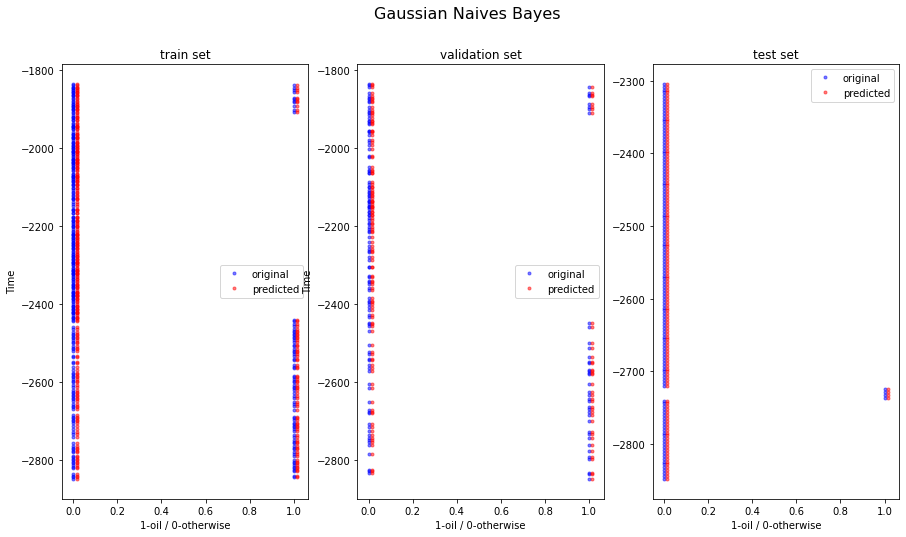

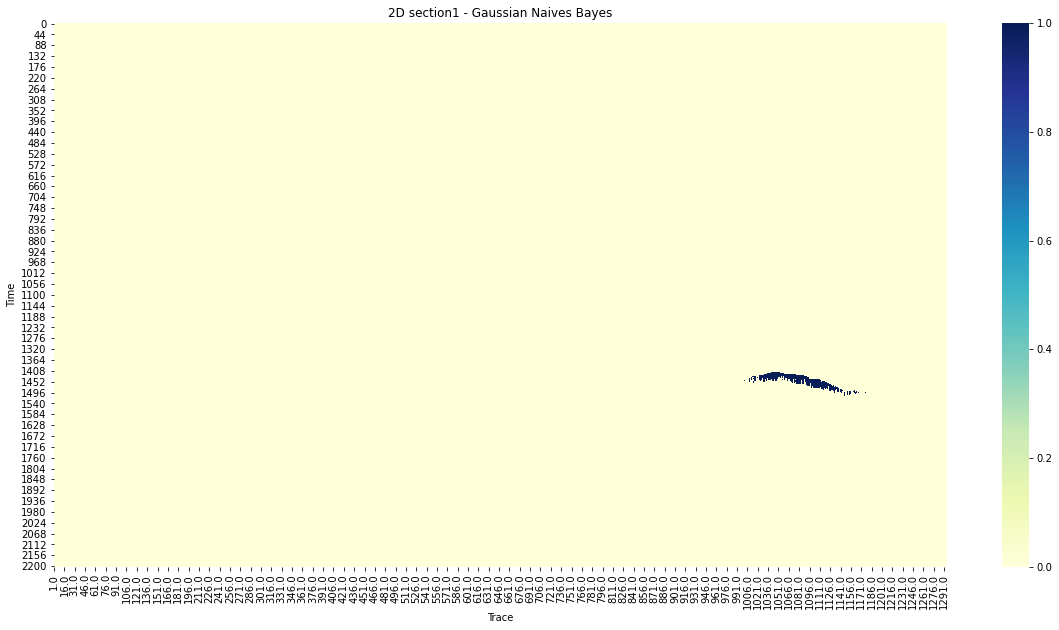

In [62]:
output_function(gnb, 'Gaussian Naives Bayes', X_train, y_train, X_val, y_val, X_test, y_test)

{'clf__var_smoothing': 1e-08}
Precision/Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on validation set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0


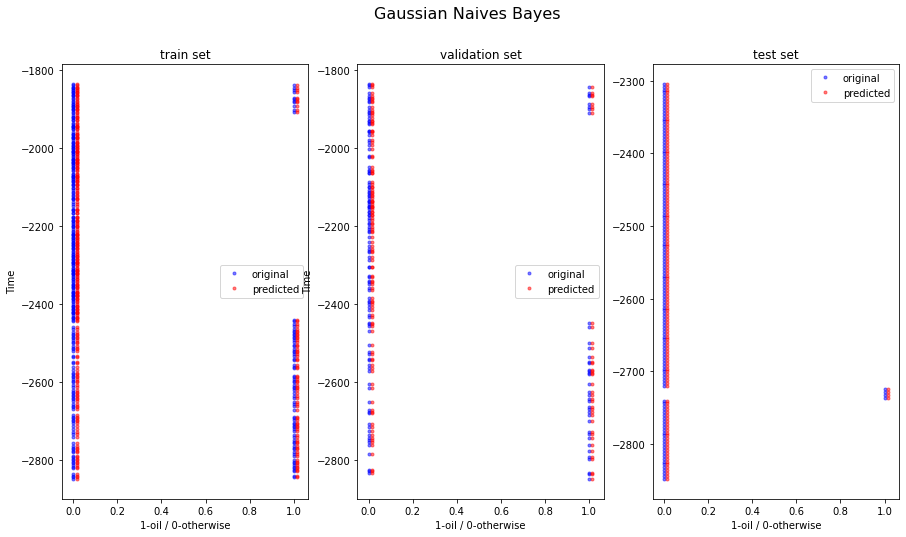

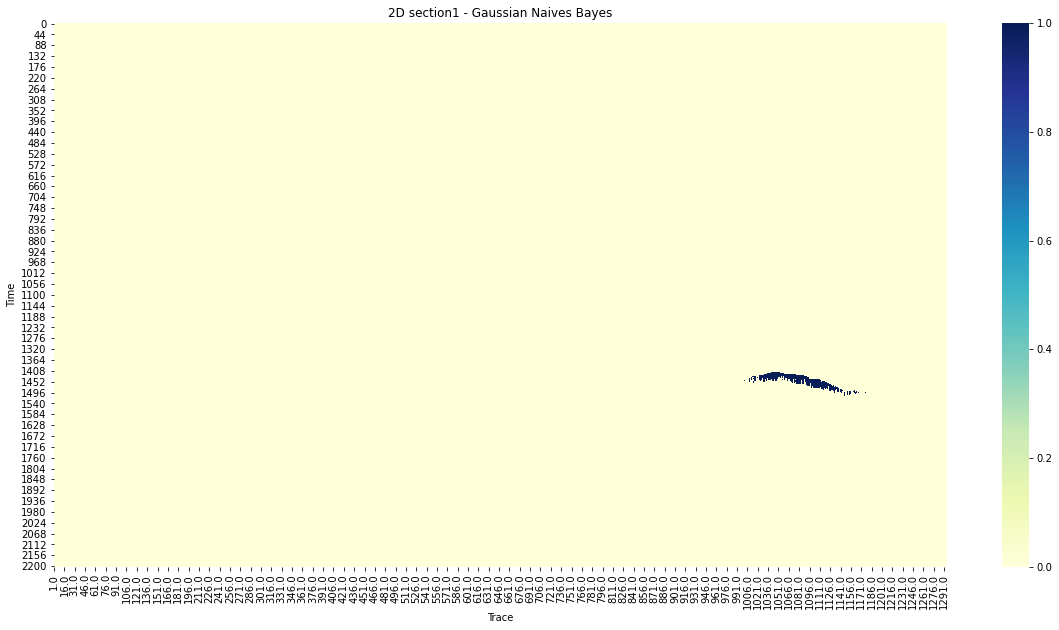

In [63]:
make_gridsearch1=True
if make_gridsearch1==True:
    cv=grid_search_function(gnb, gnb_params, X_train, y_train)
    output_function(cv, 'Gaussian Naives Bayes', X_train, y_train, X_val, y_val, X_test, y_test)
    
    # save model to the .pkl file
    filename = 'Gnb_gs.pkl'
    pickle.dump(cv, open(models_loc+filename, 'wb'))

Best Hyperparameters: {'clf__var_smoothing': 1e-08} 

Mean test score: 1.0 

Std test score: 0.0 

Precision/Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on validation set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0


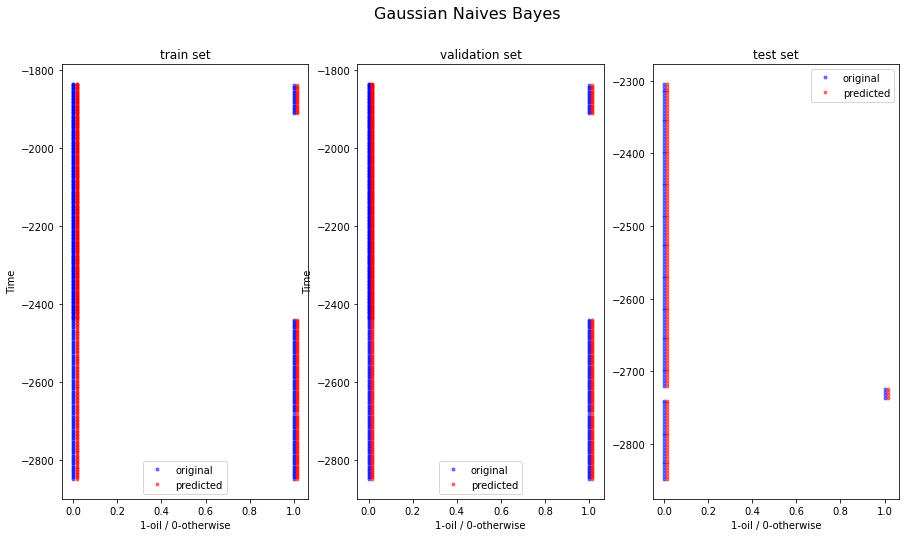

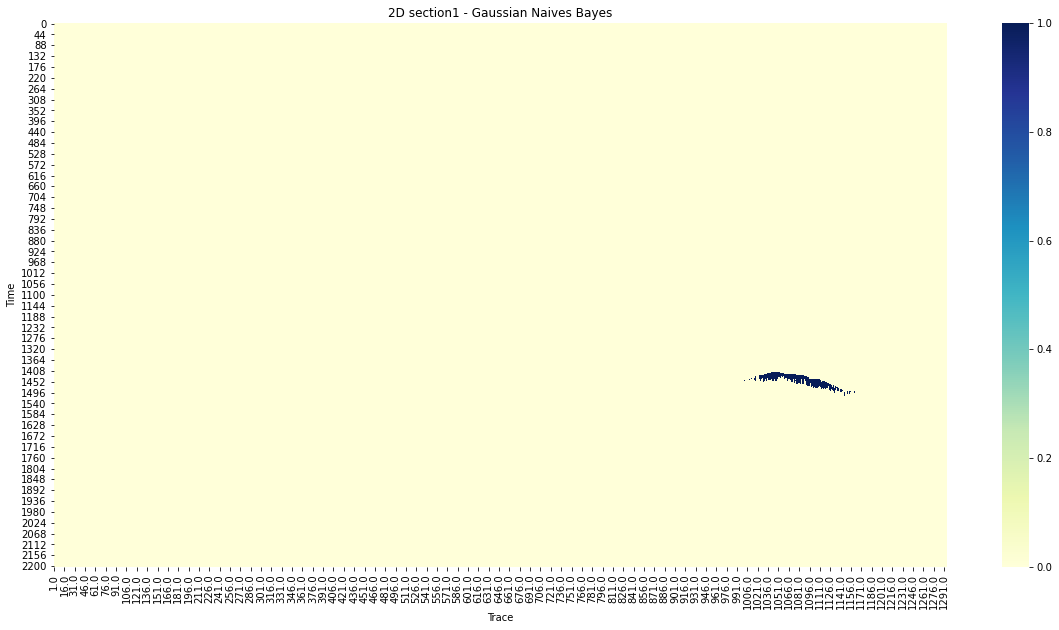

In [64]:
make_kfold1=True
if make_kfold1==True:
    result=kfold_gridsearch_function(gnb, gnb_params, X, y, K_folds)
    output_function(result, 'Gaussian Naives Bayes', X, y, X, y, X_test, y_test)
    
    # save model to the .pkl file
    filename = 'gnb_kfold.pkl'
    pickle.dump(result, open(models_loc+filename, 'wb'))

# Support Vector Machine

In [65]:
svm=Pipeline([
    ('prep',col_transform), 
    ('clf', SVC(kernel='poly', random_state=42))
    ])

svm.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index([], dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['Density', 'P_wave', 'Imp', 'Porosity', 'V_clay'], dtype='object'))])),
                ('clf', SVC(kernel='poly', random_state=42))])

Precision/Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on validation set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  0.75
F-score:  0.8571428571428571


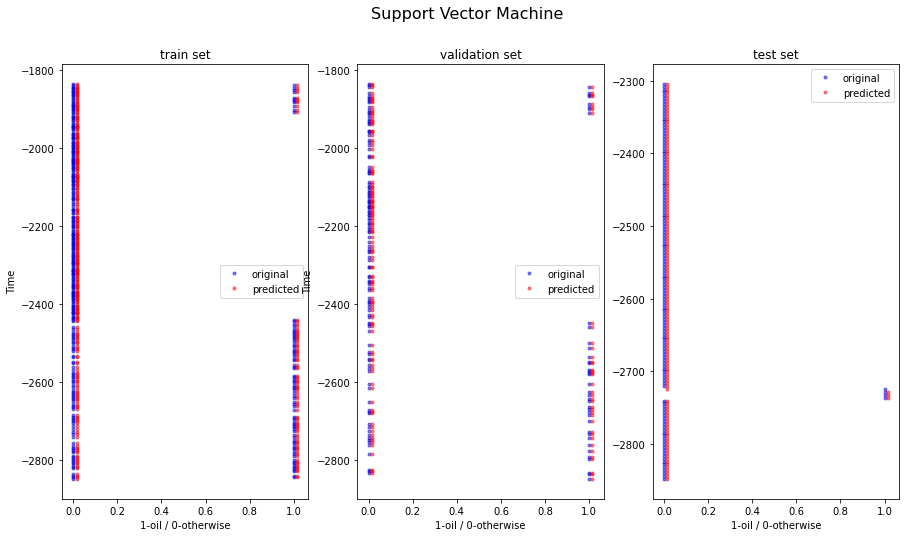

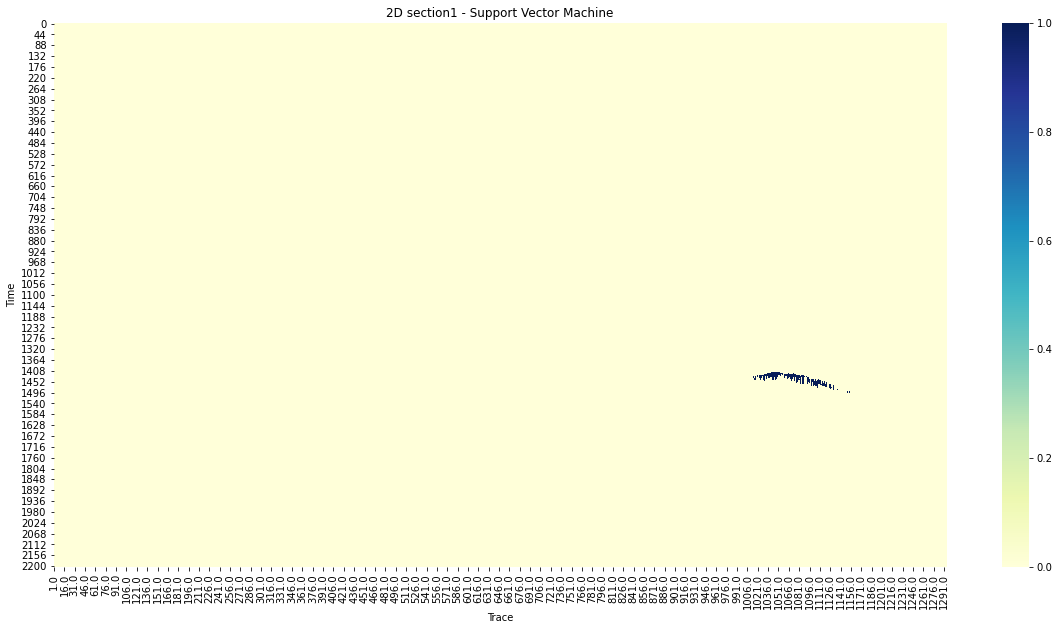

In [66]:
output_function(svm, 'Support Vector Machine', X_train, y_train, X_val, y_val, X_test, y_test)

{'clf__C': 50, 'clf__gamma': 'scale', 'clf__kernel': 'poly'}
Precision/Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on validation set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  0.75
F-score:  0.8571428571428571


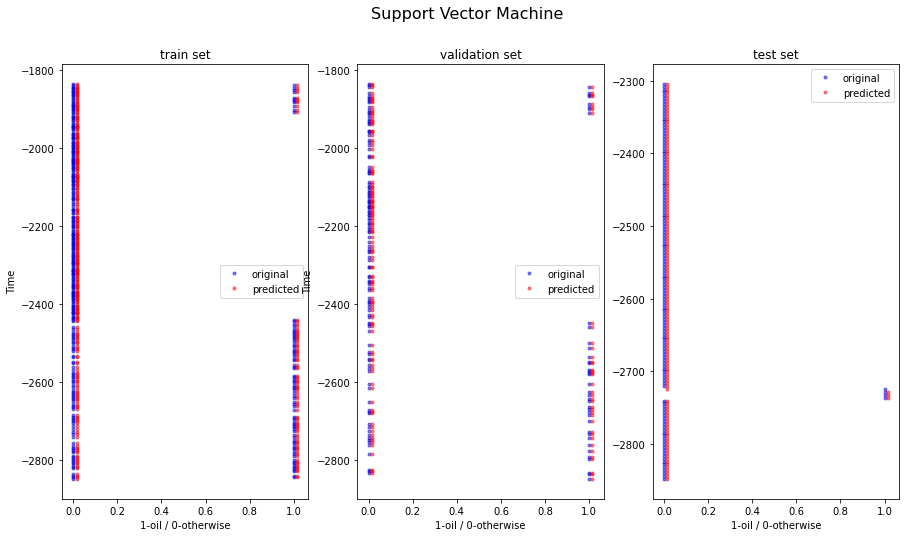

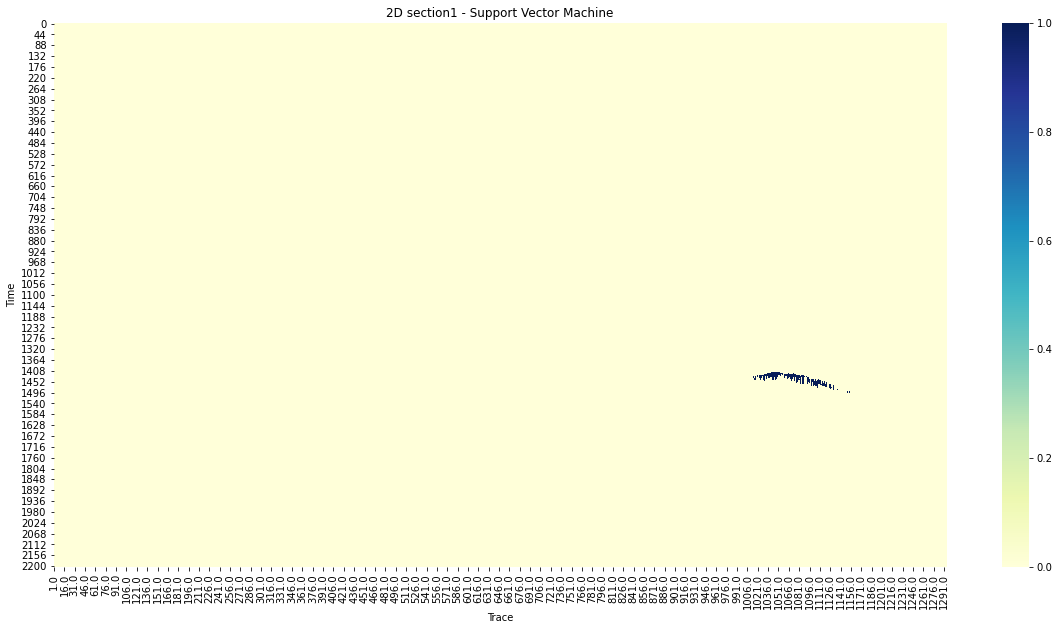

In [67]:
make_gridsearch1=True
if make_gridsearch1==True:
    cv=grid_search_function(svm, svm_params, X_train, y_train)
    output_function(svm, 'Support Vector Machine', X_train, y_train, X_val, y_val, X_test, y_test)
    
    # save model to the .pkl file
    filename = 'Svm_gs.pkl'
    pickle.dump(cv, open(models_loc+filename, 'wb'))

Best Hyperparameters: {'clf__C': 50, 'clf__gamma': 'scale', 'clf__kernel': 'poly'} 

Mean test score: 1.0 

Std test score: 0.0 

Precision/Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on validation set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  0.75
F-score:  0.8571428571428571


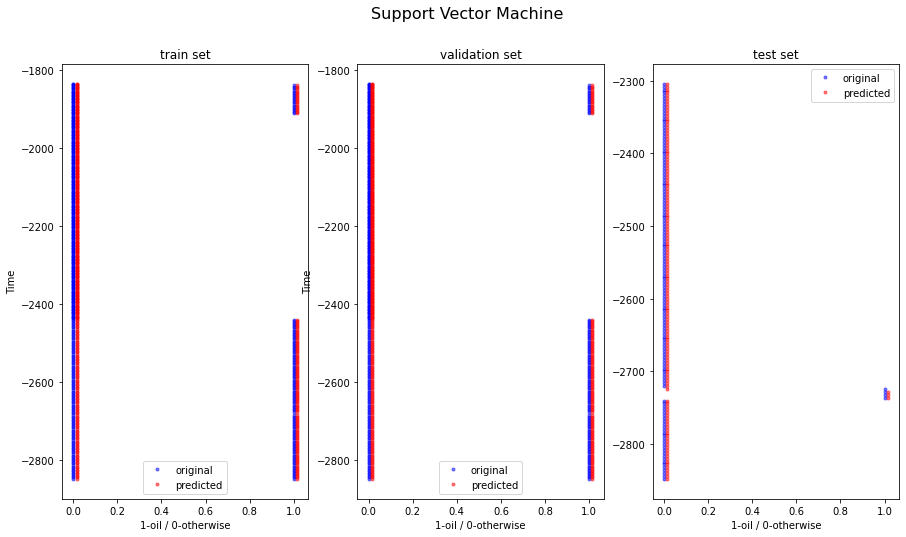

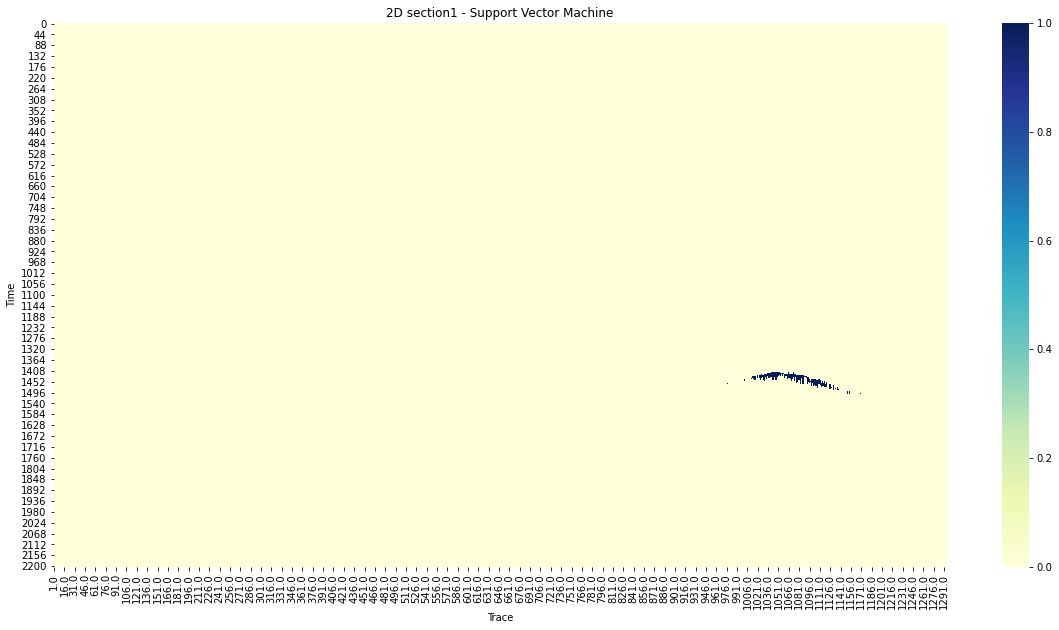

In [68]:
make_kfold1=True
if make_kfold1==True:
    result=kfold_gridsearch_function(svm, svm_params, X, y, K_folds)
    output_function(result, 'Support Vector Machine', X, y, X, y, X_test, y_test)
    
    # save model to the .pkl file
    filename = 'svm_kfold.pkl'
    pickle.dump(result, open(models_loc+filename, 'wb'))

# Gradient Boosting Classifier

In [69]:
gbc=Pipeline([
    ('prep',col_transform), 
    ('clf', GradientBoostingClassifier(random_state=42))
    ])

gbc.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index([], dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['Density', 'P_wave', 'Imp', 'Porosity', 'V_clay'], dtype='object'))])),
                ('clf', GradientBoostingClassifier(random_state=42))])

Precision/Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on validation set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  0.75
F-score:  0.8571428571428571


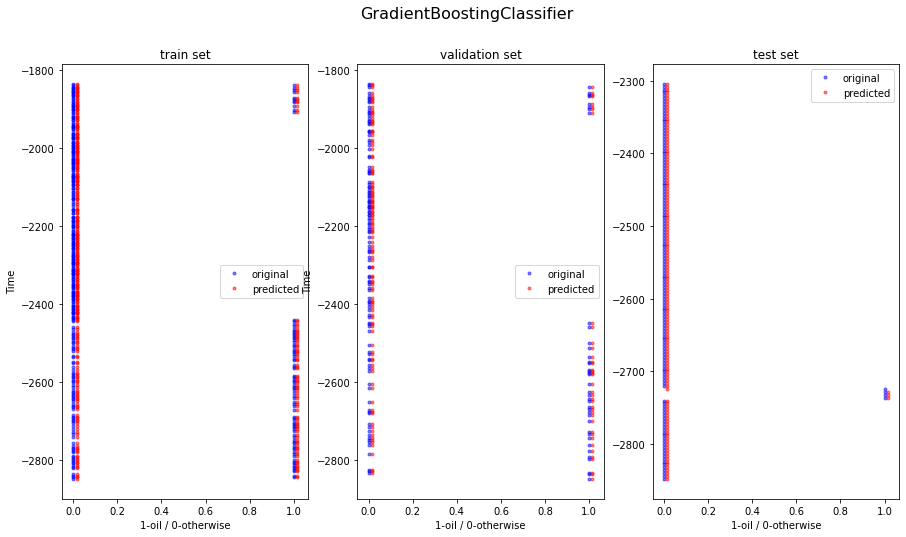

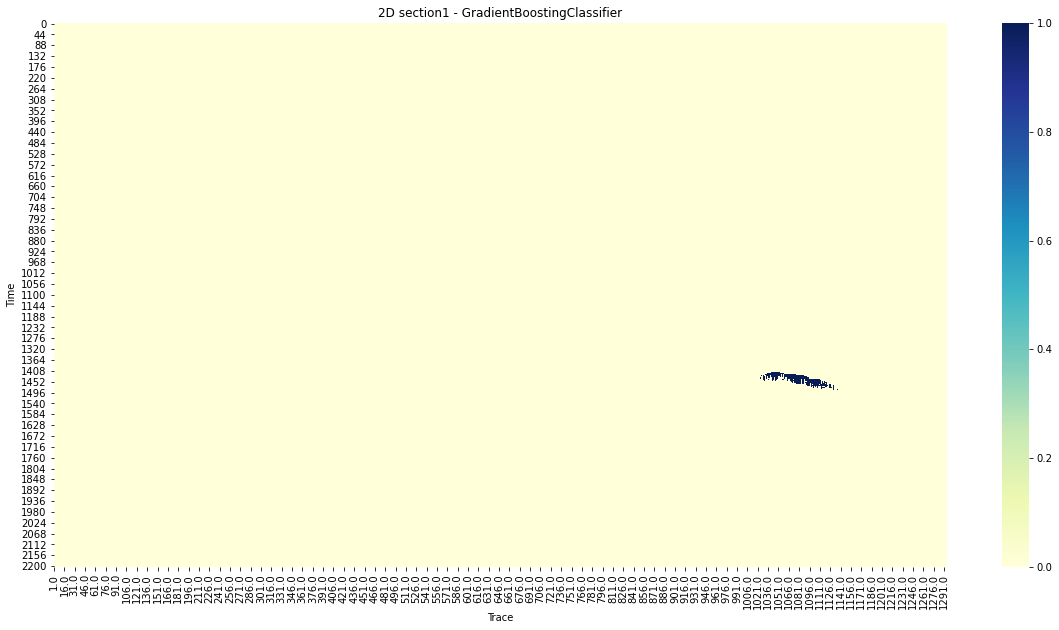

In [70]:
output_function(gbc, 'GradientBoostingClassifier', X_train, y_train, X_val, y_val, X_test, y_test)

{'clf__learning_rate': 0.001, 'clf__max_depth': 3, 'clf__n_estimators': 1000, 'clf__subsample': 0.5}
Precision/Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on validation set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  0.75
F-score:  0.8571428571428571


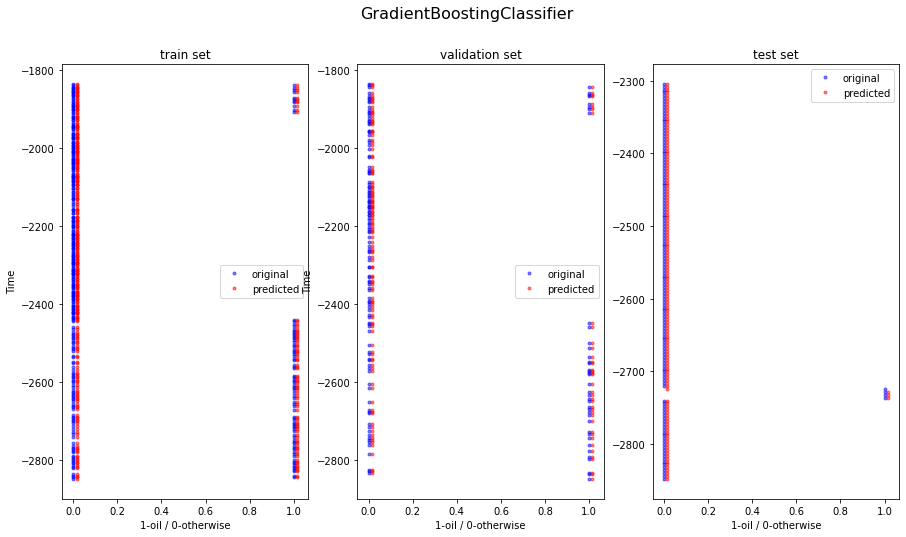

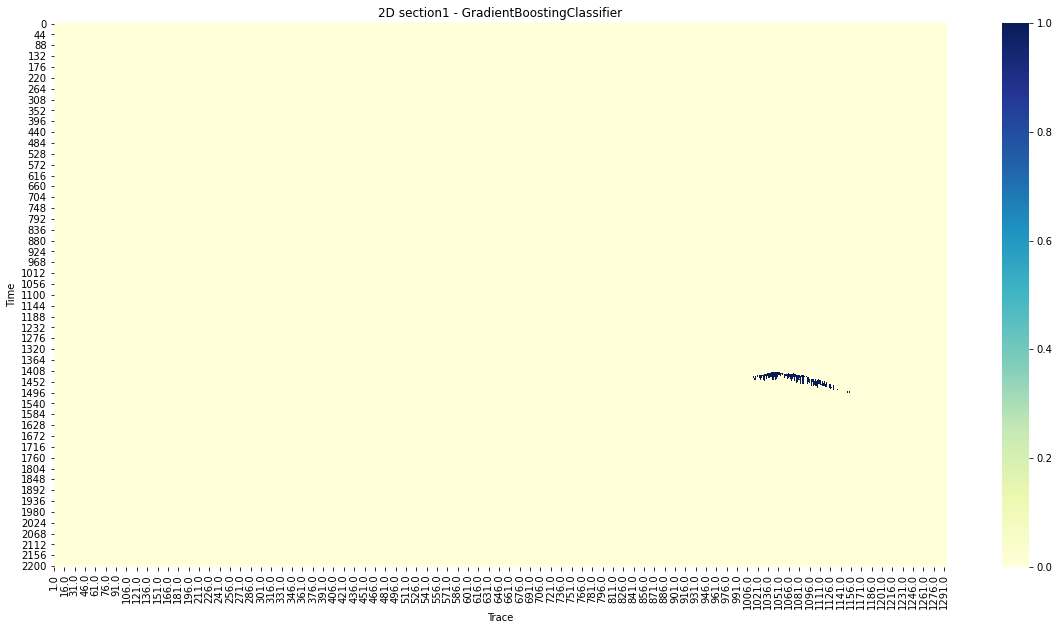

In [71]:
make_gridsearch1=True
if make_gridsearch1==True:
    cv=grid_search_function(gbc, gbc_params, X_train, y_train)
    output_function(svm, 'GradientBoostingClassifier', X_train, y_train, X_val, y_val, X_test, y_test)
    
    # save model to the .pkl file
    filename = 'gbc_gs.pkl'
    pickle.dump(cv, open(models_loc+filename, 'wb'))

Best Hyperparameters: {'clf__learning_rate': 0.001, 'clf__max_depth': 3, 'clf__n_estimators': 1000, 'clf__subsample': 0.5} 

Mean test score: 1.0 

Std test score: 0.0 

Precision/Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on validation set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  0.75
F-score:  0.8571428571428571


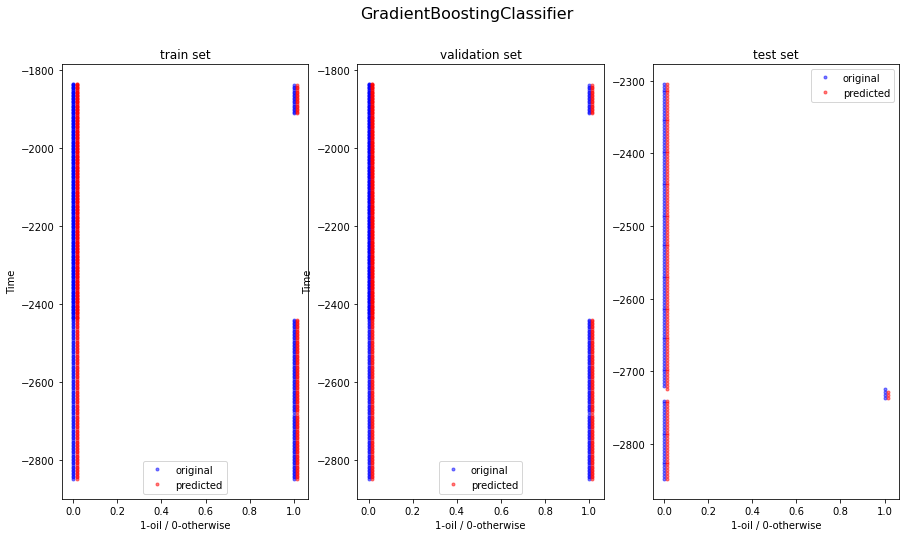

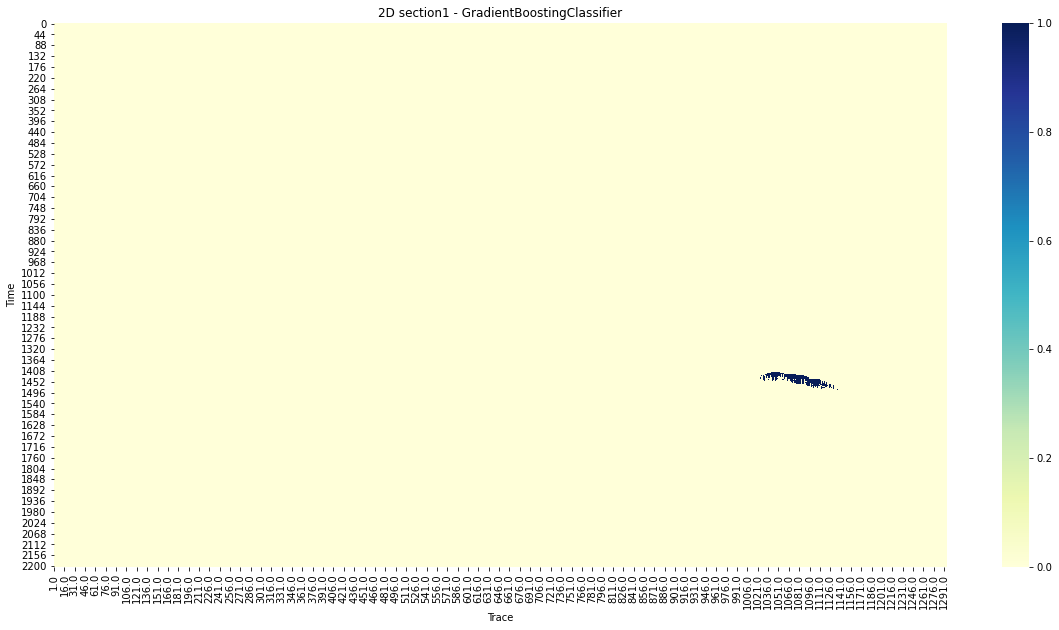

In [72]:
make_kfold1=True
if make_kfold1==True:
    result=kfold_gridsearch_function(gbc, gbc_params, X, y, K_folds)
    output_function(result, 'GradientBoostingClassifier', X, y, X, y, X_test, y_test)
    
    # save model to the .pkl file
    filename = 'gbc_kfold.pkl'
    pickle.dump(result, open(models_loc+filename, 'wb'))

## MLPClassifier (NN)

In [58]:
'''mlpc= Pipeline([
    ('prep',col_transform), 
    ('clf', MLPClassifier(solver='lbfgs', alpha=1e-5,
                          hidden_layer_sizes=(5,5,2), random_state=42))
     ])
'''
mlpc.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index([], dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['Density', 'P_wave', 'Porosity', 'Imp', 'V_clay'], dtype='object'))])),
                ('clf', MLPClassifier(random_state=42))])

Precision/Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on validation set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0


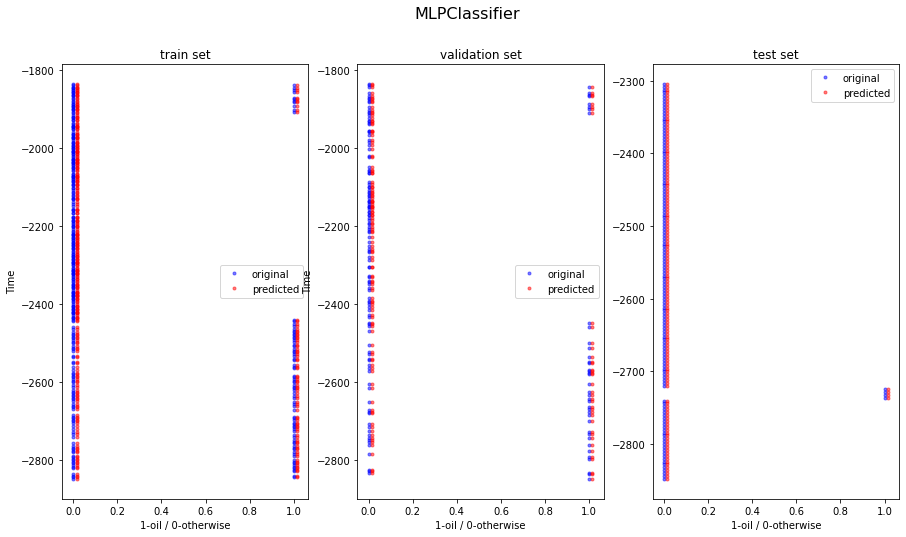

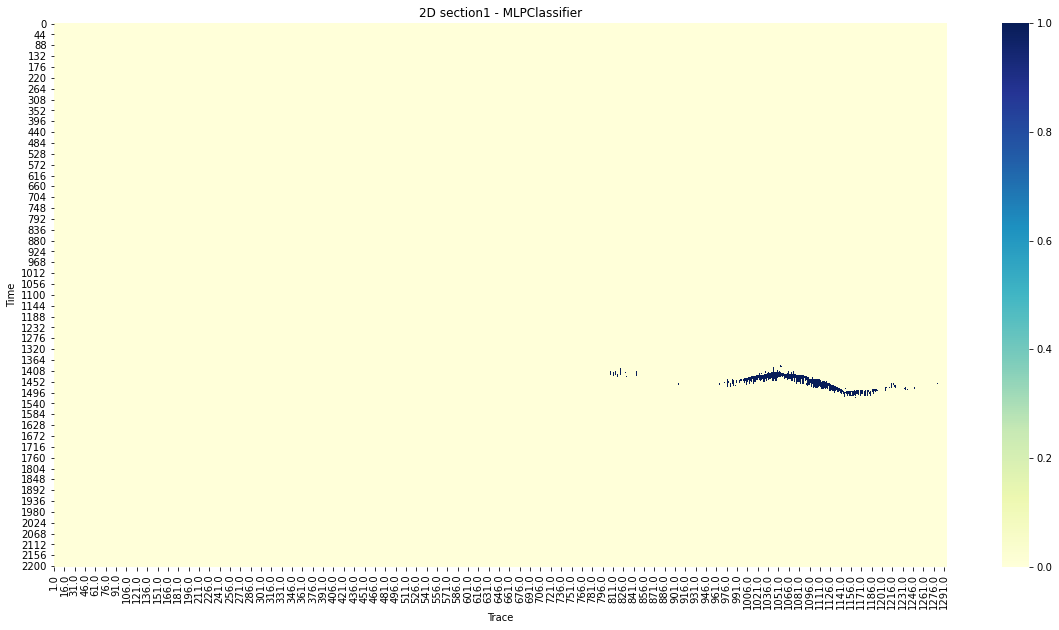

In [61]:
output_function(mlpc, 'MLPClassifier', X_train, y_train, X_val, y_val, X_test, y_test)

{'clf__activation': 'tanh', 'clf__alpha': 0.0001, 'clf__batch_size': 100, 'clf__hidden_layer_sizes': (60, 50, 10), 'clf__learning_rate': 'constant', 'clf__max_iter': 50, 'clf__momentum': True, 'clf__nesterovs_momentum': True, 'clf__random_state': 42, 'clf__solver': 'sgd'}
Precision/Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on validation set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0


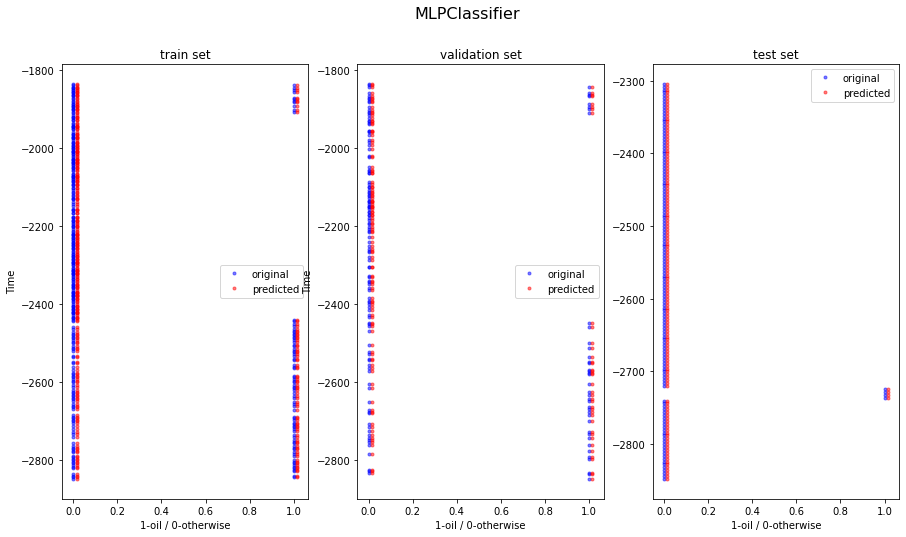

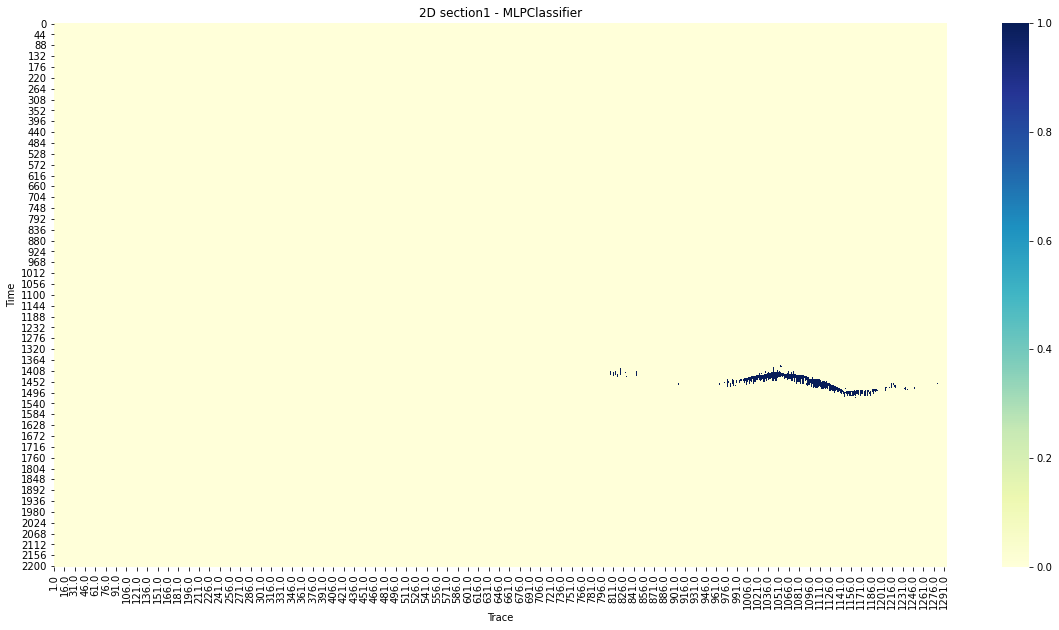

In [59]:
make_gridsearch1=True
if make_gridsearch1==True:
    cv=grid_search_function(mlpc, mlpc_params, X_train, y_train)
    output_function(mlpc, 'MLPClassifier', X_train, y_train, X_val, y_val, X_test, y_test)
    
    # save model to the .pkl file
    filename = 'mlpc_gs.pkl'
    pickle.dump(cv, open(models_loc+filename, 'wb'))

Best Hyperparameters: {'clf__activation': 'tanh', 'clf__alpha': 0.0001, 'clf__batch_size': 100, 'clf__hidden_layer_sizes': (30, 10), 'clf__learning_rate': 'constant', 'clf__max_iter': 50, 'clf__momentum': True, 'clf__nesterovs_momentum': True, 'clf__random_state': 42, 'clf__solver': 'sgd'} 

Mean test score: 1.0 

Std test score: 0.0 

Precision/Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on validation set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0


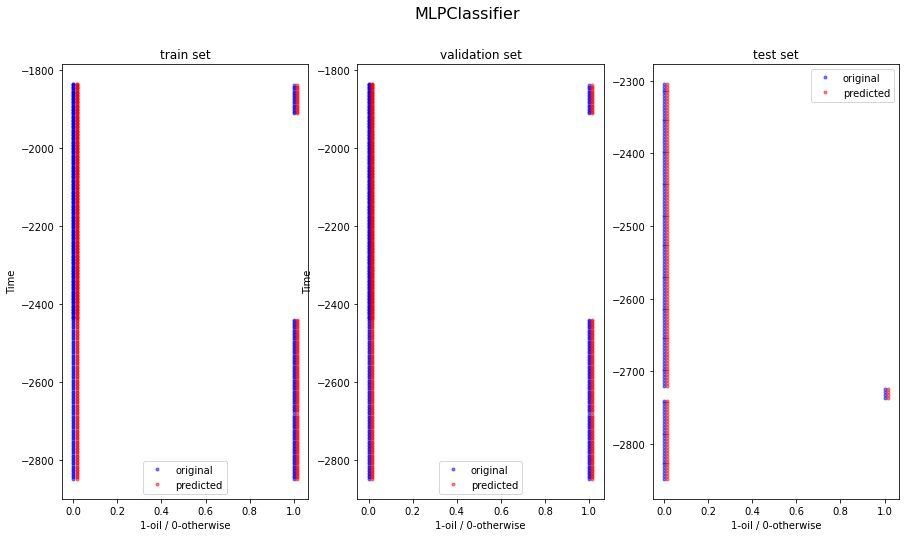

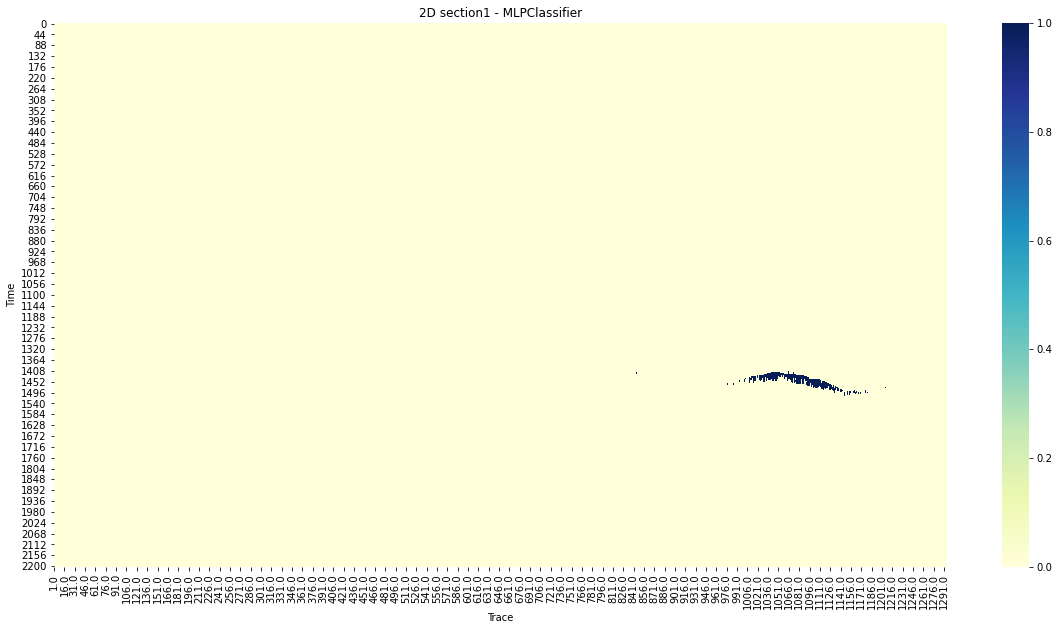

In [76]:
make_kfold1=True
if make_kfold1==True:
    result=kfold_gridsearch_function(mlpc, mlpc_params, X, y, K_folds)
    output_function(result, 'MLPClassifier', X, y, X, y, X_test, y_test)
    
    # save model to the .pkl file
    filename = 'mlpc_kfold.pkl'
    pickle.dump(result, open(models_loc+filename, 'wb'))